In [329]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.stats as stats

import scipy
import pywt
import mne
from mne.decoding import CSP
import math

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
from stats_utils import *
import glob
import os

from mne.time_frequency import AverageTFRArray
import seaborn as sns
import warnings

#warnings and logs
warnings.simplefilter(action='ignore', category=FutureWarning)
mne.set_log_level('CRITICAL')

In [330]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder


from mne.time_frequency import AverageTFRArray

Load data

In [331]:
task = 'listen'

epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data_n05to05_30Hz'
subjects_to_process = find_existing_subjects(epochs_dir)
#subjects_to_process = ['01','05']

print('processing subjects:', subjects_to_process)

processing subjects: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']


Concatenate subjects

In [332]:
def concat_epochs_subs(subjects_to_process, epochs_dir, period, drop_bads = True, **kwargs):
    """ 
    Concatenate epochs over multiple subjects. Use for CSP.
    drop_bads: whether to drop bad epochs according to some rejection criteria
    ---
    Returns: epochs object with concatenated epochs
    
    """
    eps_list = []
    for sub in subjects_to_process: 
        eps_file = os.path.join(epochs_dir, f'listen_epochs_{period}_{sub}.fif')
        eps = mne.read_epochs(eps_file)
        eps_list.append(eps)

    eps_all = mne.concatenate_epochs(eps_list)
    if drop_bads:
        eps_all.drop_bad(**kwargs)

    return eps_all



In [333]:

reject_criteria = dict(eeg=100e-6) 
eps_all_pre = concat_epochs_subs(subjects_to_process, epochs_dir, 'pre', reject = reject_criteria)
eps_all_post = concat_epochs_subs(subjects_to_process, epochs_dir, 'post', reject = reject_criteria)


Change pre/post labels 

(pre = 1, post = 2) and combine pre and post epochs

In [334]:

eps_all = mne.concatenate_epochs([eps_all_pre, eps_all_post]) #doesn't have the different labels, don't use these events

In [335]:
pre_labels = np.ones_like(eps_all_pre.events[:, 2])  
post_labels = eps_all_post.events[:, 2]  #the default value is already 2

labels = np.hstack((pre_labels, post_labels)) #use this instead of events as labels for training
#combine epochs
eps_all = mne.concatenate_epochs([eps_all_pre, eps_all_post])

In [336]:
#mne.viz.plot_epochs_image(eps_all, combine = 'mean')

Define frequencies

In [337]:
# Classification & time-frequency parameters
tmin, tmax = -0.500, 0.5
n_cycles = 10.0  # how many complete cycles: used to define window size
min_freq = 3.0
max_freq = 30.0
n_freqs = 8  # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = n_cycles / np.max(freqs) / 2.0
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

Make CV pipeline

In [338]:
# PARAMETERS
n_splits = 6  # for cross-validation, 5 is better, here we use 3 for speed
n_components = 4 #components of CSP to keep
iir_params = dict(order=8, ftype="butter") #for filtering frequencies

# Assemble the classifier using scikit-learn pipeline
clf = make_pipeline(
    CSP(n_components=n_components, reg=None, log=True, norm_trace=False),
    LinearDiscriminantAnalysis(),
)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


CV and classification

In [339]:
# Loop through each frequency range of interest
freq_scores = {}

for freq, (fmin, fmax) in enumerate(tqdm(freq_ranges)):
    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.0)  # in seconds

    eps_filt = eps_all.copy()
    eps_filt.filter(l_freq=fmin, h_freq=fmax, picks=None, method='iir', iir_params=iir_params, verbose=None)
    X = eps_filt.get_data(copy = True)[:, :64, :]
    y = labels


    # Save mean scores over folds for each frequency and time window
    cross_val_score_freq = cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=cv)
    freq_scores[f'{fmin}-{fmax}Hz'] = cross_val_score_freq

    #freq_scores[freq] = np.mean(cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=cv), axis=0)
    print(f'{fmin}-{fmax}Hz', cross_val_score_freq)
    
    

 14%|█▍        | 1/7 [04:20<26:03, 260.57s/it]

3.0-6.857142857142858Hz [0.64191688 0.66858354 0.66584539 0.64518293 0.63416635 0.65082723]


 29%|██▊       | 2/7 [10:43<27:42, 332.57s/it]

6.857142857142858-10.714285714285715Hz [0.6498492  0.64632353 0.61816404 0.6037602  0.66186636 0.6214923 ]


 43%|████▎     | 3/7 [17:39<24:42, 370.73s/it]

10.714285714285715-14.571428571428571Hz [0.54717899 0.53705372 0.50305359 0.52975833 0.52165812 0.52533046]


 57%|█████▋    | 4/7 [24:05<18:49, 376.64s/it]

14.571428571428571-18.42857142857143Hz [0.57038922 0.55300837 0.54603665 0.58133056 0.55845085 0.5539499 ]


 71%|███████▏  | 5/7 [30:54<12:56, 388.34s/it]

18.42857142857143-22.285714285714285Hz [0.56098137 0.5757357  0.49598321 0.54200818 0.54865043 0.548498  ]


 86%|████████▌ | 6/7 [37:12<06:24, 384.95s/it]

22.285714285714285-26.142857142857142Hz [0.53445577 0.56003808 0.53006469 0.54448238 0.54018139 0.52604075]


100%|██████████| 7/7 [43:37<00:00, 373.99s/it]

26.142857142857142-30.0Hz [0.53859934 0.55967201 0.49671708 0.5363588  0.55286373 0.52426069]


In [340]:
freq_scores_mean = np.zeros(n_freqs-1)
for i, key in enumerate(freq_scores.keys()):
    freq_scores_mean[i] = np.mean(freq_scores[key])

(0.4, 1.0)

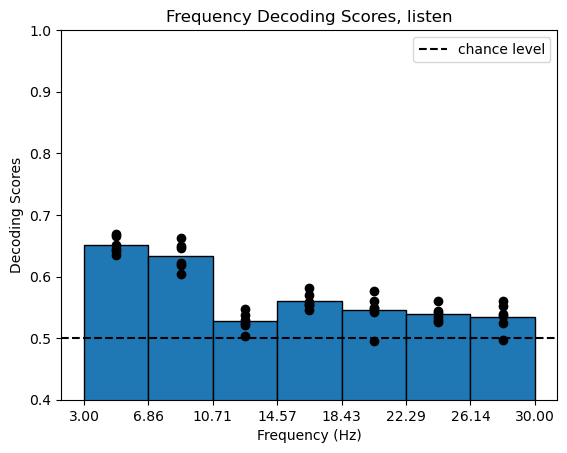

In [370]:
plt.bar(freqs[:-1], freq_scores_mean, width=np.diff(freqs)[0], align="edge", edgecolor="black")
plt.xticks(freqs)
plt.ylim([0, 1])
plt.axhline(
    0.5, color="k", linestyle="--", label="chance level"
)

for i, freq in enumerate(freq_scores.keys()):
    freq_range = freq_ranges[i]
    freq_toplot = np.mean(freq_range)
    freq_xpos = [freq_toplot]*n_splits
    plt.scatter(freq_xpos,freq_scores[freq], color = 'black')

plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decoding Scores")
plt.title(f"Frequency Decoding Scores, {task}")
plt.ylim(0.4, 1)

In [349]:
freqs

array([ 3.        ,  6.85714286, 10.71428571, 14.57142857, 18.42857143,
       22.28571429, 26.14285714, 30.        ])

In [357]:
freq_ranges

[(np.float64(3.0), np.float64(6.857142857142858)),
 (np.float64(6.857142857142858), np.float64(10.714285714285715)),
 (np.float64(10.714285714285715), np.float64(14.571428571428571)),
 (np.float64(14.571428571428571), np.float64(18.42857142857143)),
 (np.float64(18.42857142857143), np.float64(22.285714285714285)),
 (np.float64(22.285714285714285), np.float64(26.142857142857142)),
 (np.float64(26.142857142857142), np.float64(30.0))]

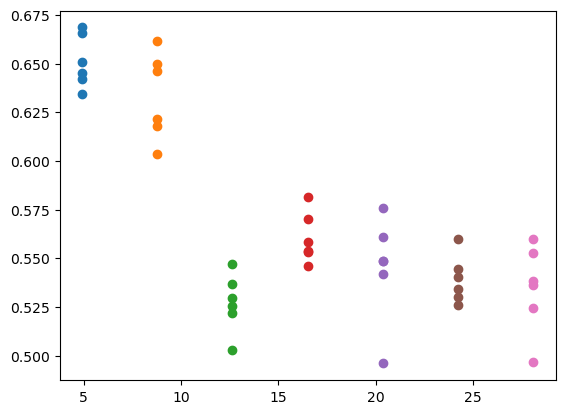

In [363]:
for i, freq in enumerate(freq_scores.keys()):
    freq_range = freq_ranges[i]
    freq_toplot = np.mean(freq_range)
    freq_xpos = [freq_toplot]*n_splits
    plt.scatter(freq_xpos,freq_scores[freq])
    

In [347]:
scores_df= pd.DataFrame(freq_scores)

In [348]:
scores_df

,3.0-6.857142857142858Hz,6.857142857142858-10.714285714285715Hz,10.714285714285715-14.571428571428571Hz,14.571428571428571-18.42857142857143Hz,18.42857142857143-22.285714285714285Hz,22.285714285714285-26.142857142857142Hz,26.142857142857142-30.0Hz
0,0.641917,0.649849,0.547179,0.570389,0.560981,0.534456,0.538599
1,0.668584,0.646324,0.537054,0.553008,0.575736,0.560038,0.559672
2,0.665845,0.618164,0.503054,0.546037,0.495983,0.530065,0.496717
3,0.645183,0.603760,0.529758,0.581331,0.542008,0.544482,0.536359
4,0.634166,0.661866,0.521658,0.558451,0.548650,0.540181,0.552864
5,0.650827,0.621492,0.525330,0.553950,0.548498,0.526041,0.524261


In [345]:
freq_scores

{'3.0-6.857142857142858Hz': array([0.64191688, 0.66858354, 0.66584539, 0.64518293, 0.63416635,
        0.65082723]),
 '6.857142857142858-10.714285714285715Hz': array([0.6498492 , 0.64632353, 0.61816404, 0.6037602 , 0.66186636,
        0.6214923 ]),
 '10.714285714285715-14.571428571428571Hz': array([0.54717899, 0.53705372, 0.50305359, 0.52975833, 0.52165812,
        0.52533046]),
 '14.571428571428571-18.42857142857143Hz': array([0.57038922, 0.55300837, 0.54603665, 0.58133056, 0.55845085,
        0.5539499 ]),
 '18.42857142857143-22.285714285714285Hz': array([0.56098137, 0.5757357 , 0.49598321, 0.54200818, 0.54865043,
        0.548498  ]),
 '22.285714285714285-26.142857142857142Hz': array([0.53445577, 0.56003808, 0.53006469, 0.54448238, 0.54018139,
        0.52604075]),
 '26.142857142857142-30.0Hz': array([0.53859934, 0.55967201, 0.49671708, 0.5363588 , 0.55286373,
        0.52426069])}

Train on full dataset to see CSP patterns

In [342]:
ep_ex = mne.read_epochs('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_02.fif')

In [343]:
"""
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp.fit_transform(eps_all.get_data(copy = True)[:,:64,:], labels)

ch_names_64, _ = load_channels()
eeg_ch_names = ch_names_64
new_info = mne.pick_info(ep_ex.info, sel=[ep_ex.info['ch_names'].index(ch) for ch in eeg_ch_names])
csp.plot_patterns(new_info, ch_type="eeg", units="Patterns (AU)", size=1.5)"""

'\ncsp = CSP(n_components=4, reg=None, log=True, norm_trace=False)\ncsp.fit_transform(eps_all.get_data(copy = True)[:,:64,:], labels)\n\nch_names_64, _ = load_channels()\neeg_ch_names = ch_names_64\nnew_info = mne.pick_info(ep_ex.info, sel=[ep_ex.info[\'ch_names\'].index(ch) for ch in eeg_ch_names])\ncsp.plot_patterns(new_info, ch_type="eeg", units="Patterns (AU)", size=1.5)'